## Problem understanding and approach development.

1. In this approach, structure perimeter and category detection from satellite images is seen as a semantic segmentation problem. To this end, annotation masks are created from the annotation json files to be used as training data for the semantic segmentation model.

2. Due to the small dataset size, significant image augmentations are used to enable and enhance model training.

3. The model used is a U-Net model which uses a pretrained EfficientNet backbone.

4. Multiple such models with varying input image sizes are ensembled (linear combination) to provide the final prediction.


### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [ ]:
# Use requirements.txt or download individual packages as shown below
! pip install -r requirements.txt

In [ ]:
!pip uninstall -y tensorflow
! pip install --upgrade --ignore-installed tensorflow-gpu==1.13.1
! pip install keras==2.2.4
! pip install Keras-Applications==1.0.7
! pip install h5py==2.10.0

  Using cached https://files.pythonhosted.org/packages/2c/65/8dc8fc4a263a24f7ad935b72ad35e72ba381cb9e175b6a5fe086c85f17a7/tensorflow_gpu-1.13.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/81/6f/6d292b7012abe5dd797259d10a788935bfc96bc6c835f2d529d95f1e388e/grpcio-1.36.1-cp37-cp37m-manylinux2014_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/70/8a/064b4077e3d793f877e3b77aa64f56fa49a4d37236a53f78ee28be009a16/numpy-1.20.1-cp37-cp37m-manylinux2010_x86_64.whl
Processing /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6/termcolor-1.1.0-cp37-none-any.whl
  Using cached https://files.pythonhosted.org/packages/65/63/39d04c74222770ed1589c0eaba06c05891801219272420b40311cd60c880/wheel-0.36.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl
  Using cached https://files.py

  Using cached https://files.pythonhosted.org/packages/90/85/64c82949765cfb246bbdaf5aca2d55f400f792655927a017710a78445def/Keras_Applications-1.0.7-py2.py3-none-any.whl
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
ERROR: tensorflow-gpu 1.13.1 has requirement tensorboard<1.14.0,>=1.13.0, but you'll have tensorboard 2.4.1 which is incompatible.
ERROR: tensorflow-gpu 1.13.1 has requirement tensorflow-estimator<1.14.0rc0,>=1.13.0, but you'll have tensorflow-estimator 2.4.0 which is incompatible.
  Found existing installation: Keras-Applications 1.0.8
    Uninstalling Keras-Applications-1.0.8:
      Successfully uninstalled Keras-Applications-1.0.8
  Using cached https://files.pythonhosted.org/packages/3f/c0/abde58b837e066bca19a3f7332d9d0493521d7dd6b48248451a9e3fe2214/h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
  Found existing installation: h5py 3.2.1
    Uninstalling h5py-3.2.1:
      Successful

In [ ]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
# !pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

Requirement already up-to-date: segmentation-models in /usr/local/lib/python3.7/dist-packages (1.0.1)
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-7m6b6ujp
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-7m6b6ujp
  Created wheel for albumentations: filename=albumentations-0.5.2-cp37-none-any.whl size=88135 sha256=0bddade86016ad2b9fe365143f9367bbb11bd253808c51bab7d07c88191233f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-_iysxiqr/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [ ]:
import segmentation_models as sm

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Segmentation Models: using `keras` framework.


# Loading dataset

**Satellite Image segmentation.**
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
*Note*: All images have 1728 pixels height and 1571 pixels width.

In total, the data has (based on 72 annotation files):

1. 6789 labels for Houses.
2. 9403 labels for Buildings.
3. 301 labels for Sheds.

This statistic is relavant since it highlights the imbalance in the dataset. One way to handle this imbalance is dice loss which is employed here. However, another point to keep in mind is that these numbers cannot directly be converted to label areas. An average building may be much larger (area wise) than a shed or even a house.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import json
import numpy as np
from pycocotools import mask
from skimage import measure

# Creating the directory structure

In [ ]:
! . ./setup.sh

In [ ]:
DATA_DIR = './incubit_data/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Dataloader and utility functions 

In [ ]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """Satellite Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabelled','houses','buildings','sheds']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask, self.images_fps[i]
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            # data.append(self.dataset[j])
            data.append(self.dataset[self.indexes[j]][:2])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

## Sample Image and Mask

Visualizing a sample from the training dataset.

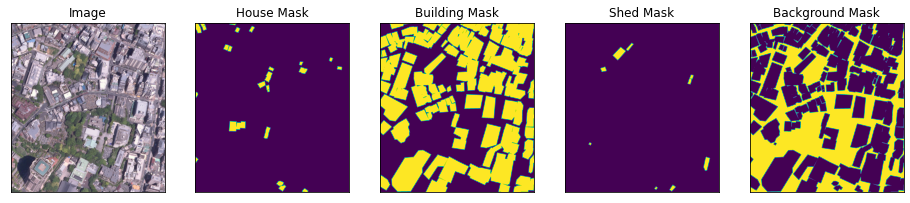

In [ ]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['houses', 'buildings','sheds'])

image, mask, file_name = dataset[12] # grab a sample
visualize(
    image=image, 
    house_mask=mask[..., 0].squeeze(),
    building_mask=mask[..., 1].squeeze(),
    shed_mask=mask[..., 2].squeeze(),
    background_mask=mask[..., 3].squeeze(),
)

## Overlaying mask on the sample image

(1728, 1571, 3)
(1728, 1571)


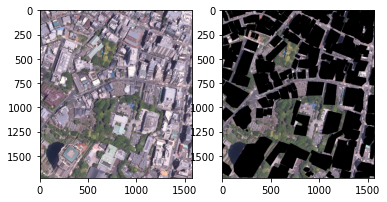

In [ ]:
mask_struct = 3 # 0=houses, 1=buildings, 2=sheds, 3=background
mask_thresh = np.array(mask[...,mask_struct].squeeze())
mask_thresh[mask_thresh>=0.1] =1
mask_thresh[mask_thresh<0.1] = 0
mask_thresh = mask_thresh.astype(np.uint8)
# plt.imshow(mask_thresh,cmap=plt.cm.gray)

print(image.shape)
print(mask_thresh.shape)
masked = cv2.bitwise_and(image, image, mask = mask_thresh)
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(image)
# plt.imshow(image)
axarr[1].imshow(masked)

## Augmentations

Data augmentation is a powerful technique used here to increase the amount of data and prevent model overfitting.
More information on augmentation can be located in the following articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All these transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
Detailed explanation of image transformations is provided at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [ ]:
import albumentations as A

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation(size=384):
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        # A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # A.RandomCrop(height=320, width=320, always_apply=True),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # A.RandomCrop(height=320, width=320, always_apply=True),

        # A.RandomCrop(height=384, width=384, always_apply=True), # for PSPNet
        A.RandomCrop(height=size, width=size, always_apply=True), 


        # A.PadIfNeeded(704, 740),



        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(1728,1600)
        # A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # A.RandomCrop(height=320, width=320, always_apply=True),

    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

(1728, 1600, 3)
(1728, 1600, 4)


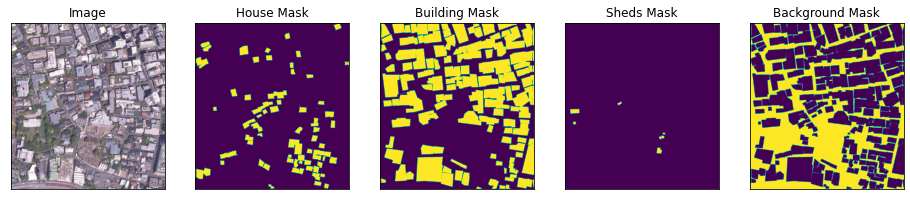

In [ ]:
# Lets look at augmented data we have
# dataset = Dataset(x_train_dir, y_train_dir, classes=['houses', 'buildings','sheds'], augmentation=get_training_augmentation())

dataset = Dataset(x_valid_dir, y_valid_dir, classes=['houses', 'buildings','sheds'], augmentation=get_validation_augmentation())


image, mask,_ = dataset[0] # get some sample


print(image.shape)
print(mask.shape)

visualize(
    image=image, 
    house_mask=mask[..., 0].squeeze(),
    building_mask=mask[..., 1].squeeze(),
    sheds_mask=mask[..., 2].squeeze(),
    background_mask=mask[..., 3].squeeze(),

)

# Segmentation model training

or jump straight to [inference](#Model-Inference-and-Evaluation)
* The approach used in this repository is a U-Net architecture with a pretrained (on imagenet) EfficientNet backbone. The architecture was chosen based on winning solutions for several related competitions ([crowd AI mapping chal](https://www.crowdai.org/challenges/mapping-challenge), [SpaceNet SN6](https://spacenet.ai/sn6-challenge/) and [SpaceNet SN7](https://spacenet.ai/sn7-challenge/)).
* Two observable trends present in the competition top performers:
  * U-Net architecture with different encoders 
  * Ensembling several models for semantic segmentation.
* For the former, research literature such as [this](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w22/Baheti_Eff-UNet_A_Novel_Architecture_for_Semantic_Segmentation_in_Unstructured_Environment_CVPRW_2020_paper.pdf) strongly suggests that the EfficientNet family outperforms all contemporary networks while being much smaller and faster. While not all possible combinations could be tested, U-Net with efficientNet backbone performed well in initial model testing. Since this was supported by the research literature as well as satellite image competitions, the mentioned architecture was selected.

In [ ]:
BACKBONE = 'efficientnetb5'
BATCH_SIZE = 1
CLASSES = ['houses', 'buildings','sheds']
LR = 0.0001
EPOCHS = 40
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
# model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', encoder_freeze=True)
# model = sm.PSPNet(backbone_name=BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', encoder_freeze=True)


In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (houses: 2.; buildings: 1.; sheds: 3.; background: 0.5;)
# weights inversely proportional to label's area
dice_loss = sm.losses.DiceLoss(class_weights=np.array([2, 1, 3,0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# total_loss can be imported directly from the library, above example just shows how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

Instructions for updating:
Colocations handled automatically by placer.


## Single model training

In [ ]:
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', encoder_freeze=True)
# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

# model = sm.PSPNet(backbone_name=BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', encoder_freeze=True)

# Dataset for train images
INPUT_SIZE = 768
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(size=INPUT_SIZE),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
# assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
# assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

assert train_dataloader[0][0].shape == (BATCH_SIZE, INPUT_SIZE,INPUT_SIZE, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, INPUT_SIZE, INPUT_SIZE, n_classes)


# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:220: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:334: FutureWarning: IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:198: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/aug

In [ ]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40
67/67 [==============================] - 89s 1s/step - loss: 0.7638 - iou_score: 0.2059 - f1-score: 0.2901 - val_loss: 0.6762 - val_iou_score: 0.2982 - val_f1-score: 0.4015
Epoch 2/40
67/67 [==============================] - 30s 447ms/step - loss: 0.6694 - iou_score: 0.3506 - f1-score: 0.4524 - val_loss: 0.5862 - val_iou_score: 0.3784 - val_f1-score: 0.4840
Epoch 3/40
67/67 [==============================] - 30s 448ms/step - loss: 0.6425 - iou_score: 0.4142 - f1-score: 0.5130 - val_loss: 0.5467 - val_iou_score: 0.4202 - val_f1-score: 0.5187
Epoch 4/40
67/67 [==============================] - 30s 446ms/step - loss: 0.6277 - iou_score: 0.4413 - f1-score: 0.5413 - val_loss: 0.5009 - val_iou_score: 0.4395 - val_f1-score: 0.5374
Epoch 5/40
67/67 [==============================] - 30s 445ms/step - loss: 0.6137 - iou_score: 0.4551 - f1-score: 0.5547 - val_loss: 0.5297 - val_iou_score: 0.4204 - val_f1-score: 0.5186
Epoch 6/40
67/67 [==============================] - 30s 454ms/step -

## Ensemble Training

Creating an emsemble of 7 models, feeding input images of different sizes. Final results will be computed based on a vote of sorts from all these models.

In [ ]:
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

n_models = 7 # number of models for ensembling. Also effects the image size being fed in. Check train_dataset var (augmentation).
models=[0]*n_models
history=[0]*n_models
for j in range(n_models):
    models[j] =  (sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', encoder_freeze=True))
    models[j].compile(optim, total_loss, metrics)
  
    train_dataset = Dataset(
        x_train_dir, 
        y_train_dir, 
        classes=CLASSES, 
        augmentation=get_training_augmentation(size=32*(10+2*j)),
        preprocessing=get_preprocessing(preprocess_input),)
  
    if j >= 5: # In case batch-size is set to a higher number for smaller images. Later iterations can use a batch size of 1.
        BATCH_SIZE = 1
    train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    callbacks = [
        keras.callbacks.ModelCheckpoint('./best_model_Unet_ensemble_{}.h5'.format(j), save_weights_only=True, save_best_only=True, mode='min'),
        keras.callbacks.ReduceLROnPlateau(),]
  
    print("Training initialized: model #",j)
    history[j] = (models[j].fit_generator(
        train_dataloader, 
        steps_per_epoch=len(train_dataloader), 
        epochs=EPOCHS, 
        callbacks=callbacks, 
        validation_data=valid_dataloader, 
        validation_steps=len(valid_dataloader),
    ))

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:220: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:334: FutureWarning: IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:198: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/aug

Training initialized: model # 0
Epoch 1/40
67/67 [==============================] - 54s 809ms/step - loss: 0.8884 - iou_score: 0.1067 - f1-score: 0.1638 - val_loss: 0.7359 - val_iou_score: 0.2858 - val_f1-score: 0.3631
Epoch 2/40
67/67 [==============================] - 23s 348ms/step - loss: 0.8023 - iou_score: 0.2389 - f1-score: 0.3208 - val_loss: 0.7060 - val_iou_score: 0.2953 - val_f1-score: 0.3893
Epoch 3/40
67/67 [==============================] - 23s 347ms/step - loss: 0.7713 - iou_score: 0.3889 - f1-score: 0.4747 - val_loss: 0.6798 - val_iou_score: 0.3163 - val_f1-score: 0.4180
Epoch 4/40
67/67 [==============================] - 23s 338ms/step - loss: 0.7702 - iou_score: 0.4599 - f1-score: 0.5435 - val_loss: 0.7141 - val_iou_score: 0.2699 - val_f1-score: 0.3659
Epoch 5/40
67/67 [==============================] - 25s 372ms/step - loss: 0.7854 - iou_score: 0.4589 - f1-score: 0.5368 - val_loss: 0.6857 - val_iou_score: 0.3060 - val_f1-score: 0.4085
Epoch 6/40
67/67 [===============

## Visualizing training metrics

Plot shown below captures IOU Score and Loss for the single model trained.

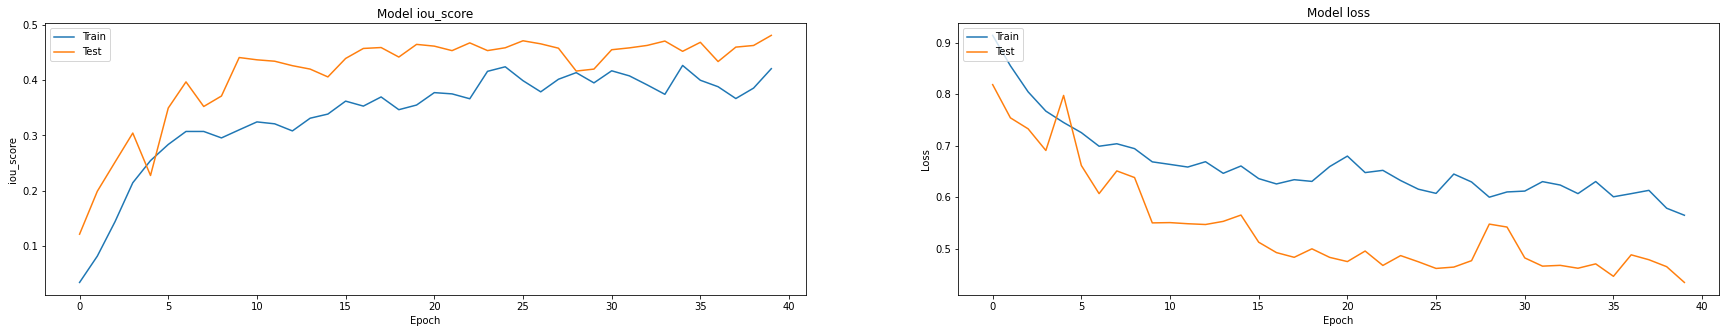

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.figure().savefig('training_metrics.png')
plt.show()

# Model Inference and Evaluation

In [ ]:
# Loading the test dataset for inference
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

## Loading all trained ensemble models

In [ ]:
# load best weights
# model.load_weights('best_model_unet_true.h5') 
n_models = 7
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet', encoder_freeze=True)
models = [0]*n_models
for j in range(n_models):
    models[j] = model
#     models[j].compile(optim, total_loss, metrics)
    models[j].load_weights('best_model_Unet_ensemble_{}.h5'.format(j))

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
115515392/115515256 [==============================] - 6s 0us/step


## Ensemble Inference and visualization

In [ ]:
masks_to_check = [] # list of images overlayed with segments

def inference(models=models, test_dataset=test_dataset, visualize_bool=True):
    output_masks = []
    file_names = []
    for i in range(len(test_dataset)):
        image, gt_mask,file_name = test_dataset[i]
        file_names.append(file_name)
        image = np.expand_dims(image, axis=0)
        results = np.zeros( (1,1728,1600,4) )
        for j in range(n_models):
            results = results + models[j].predict(image)
    print(results.shape)
    pr_mask = results/n_models
    output_masks.append(pr_mask)
    # print(pr_mask.shape)
    predicted_annotations, segged_mask = poly_from_mask(pr_mask, file_name)

    if visualize_bool:
        visualize(
            image=denormalize(image.squeeze()),
            gt_mask=gt_mask.squeeze(),
            pr_mask=pr_mask.squeeze(),
            house_mask=pr_mask[...,0].squeeze(),
            building=pr_mask[...,1].squeeze(),
            shed_mask=pr_mask[...,2].squeeze(),
            bg_mask=pr_mask[...,3].squeeze(),
            segmented_mask = segged_mask,
        )
    return output_masks, file_names

def binarize_mask(mask_for_binarization, threshold=0.6):
    mask_thresh = np.array(mask_for_binarization.squeeze())
    mask_thresh = np.where(mask_thresh>threshold,1, 0)
    print(mask_thresh.shape)
    return mask_thresh

masks_to_check=[]
def poly_from_mask(input_mask, file_name):
    label_dict = {0:'Houses',1:'Buildings',2:'Sheds/Garages'}
    color_dict = {0:(0,0,255),1:(0,0,255),2:(255,0,0)}
    # ground_truth_binary_mask = binarize_mask(input_mask)
    allchannel_binary_mask = binarize_mask(input_mask)
    orig_image = cv2.imread(file_name)
    annotation = {
        "filename":file_name,
        "labels":[],
        # "segmentation": [],
    }

    for label in range(len(label_dict)):
        ground_truth_binary_mask = allchannel_binary_mask[...,label]
        # print(ground_truth_binary_mask[...,0].shape)
        masker = np.ones(ground_truth_binary_mask.shape, dtype=np.uint8) * 255
        fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
        encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask.astype(np.uint8))
        ground_truth_area = mask.area(encoded_ground_truth)
        ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
        contours = measure.find_contours(ground_truth_binary_mask, 0.8)
        label_predictions = {"name":label_dict[label], "annotations":[]}
        # label_predictions = {"name":label_dict[label], "id":[], "segmentation":[]}
        for n,contour in enumerate(contours):
            contour = np.flip(contour, axis=1)
            cv2.drawContours(orig_image, [contour.astype(int)], -1, color_dict[label], thickness=5)
            segmentation = contour.ravel().tolist()
            # annotation["segmentation"].append(segmentation)
            # annotation["labels"]
            internal_dict = {"id":n,"segmentation":segmentation}
            label_predictions["annotations"].append(internal_dict)

        annotation["labels"].append(label_predictions)
        masker = np.invert(masker)
        masks_to_check.append(orig_image)
        # plt.imshow(masker, cmap=plt.cm.gray)
    return annotation, orig_image

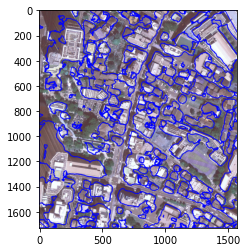

In [ ]:
# Sample test image with inference results plotted on the image.
plt.imshow(masks_to_check[2])

(1, 1728, 1600, 4)
(1728, 1600, 4)


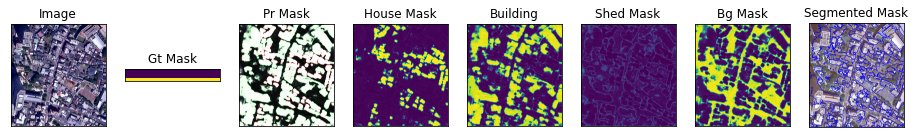

(1, 1728, 1600, 4)
(1728, 1600, 4)


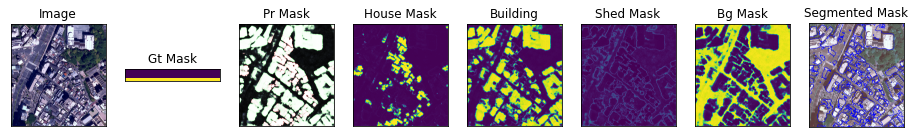

(1, 1728, 1600, 4)
(1728, 1600, 4)


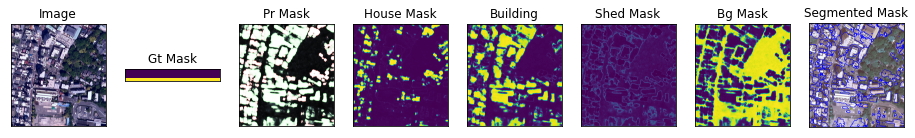

(1, 1728, 1600, 4)
(1728, 1600, 4)


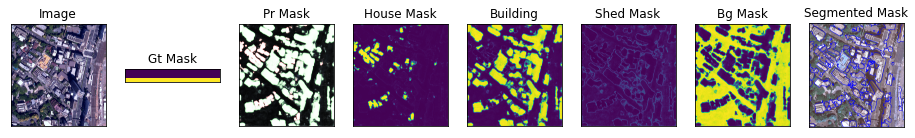

(1, 1728, 1600, 4)
(1728, 1600, 4)


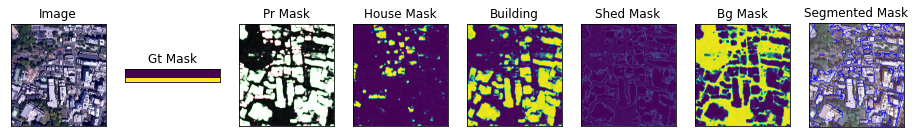

(1, 1728, 1600, 4)
(1728, 1600, 4)


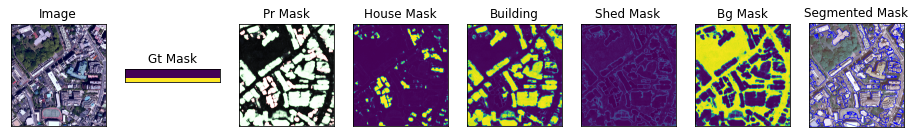

(1, 1728, 1600, 4)
(1728, 1600, 4)


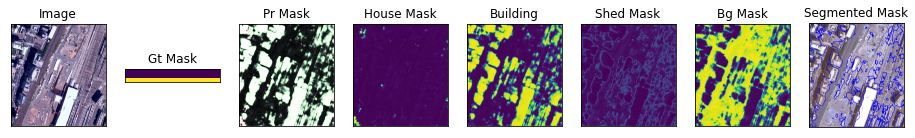

(1, 1728, 1600, 4)
(1728, 1600, 4)


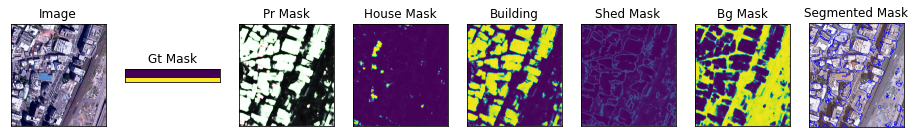

(1, 1728, 1600, 4)
(1728, 1600, 4)


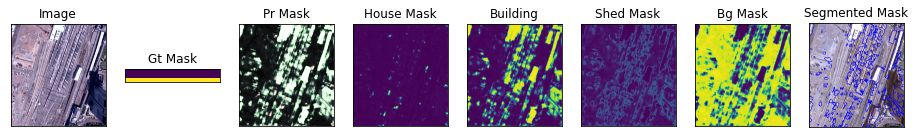

In [ ]:
output_masks, file_names = inference(visualize_bool=True)

# Pr Mask: Predicted Mask
# House Mask: House segments in satellite image
# Building: Building segments in satellite image
# Shed: Shed segments in satellite image
# Segmented Mask: Original image with segmentation contours plotted on

In [ ]:
scores = models[0].evaluate_generator(valid_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

## Visualization of results on test dataset (single model)

(1, 1728, 1600, 4)
(1728, 1600, 4)


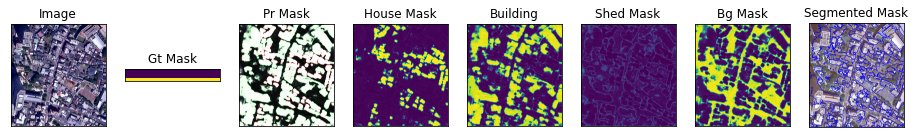

(1, 1728, 1600, 4)
(1728, 1600, 4)


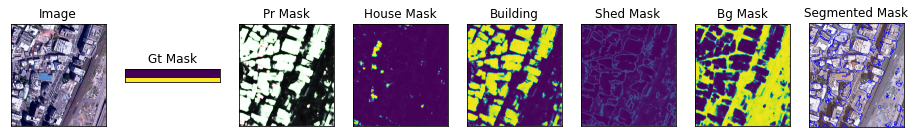

(1, 1728, 1600, 4)
(1728, 1600, 4)


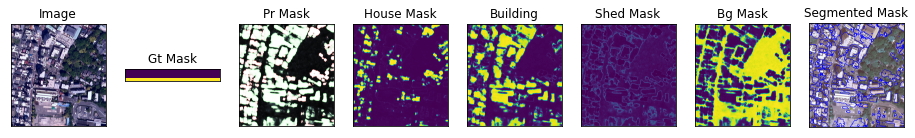

(1, 1728, 1600, 4)
(1728, 1600, 4)


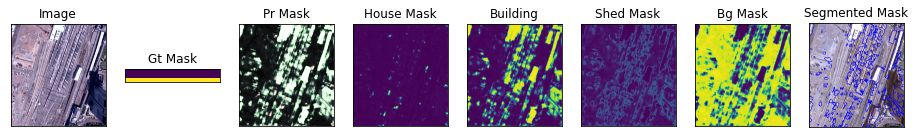

(1, 1728, 1600, 4)
(1728, 1600, 4)


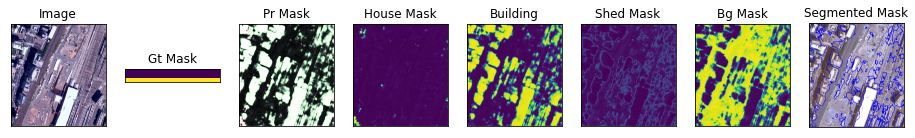

In [ ]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask, file_name = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = models[4].predict(image)
    print(pr_mask.shape)
    predicted_annotations, segged_mask = poly_from_mask(pr_mask, file_name)

    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
        house_mask=pr_mask[...,0].squeeze(),
        building=pr_mask[...,1].squeeze(),
        shed_mask=pr_mask[...,2].squeeze(),
        bg_mask=pr_mask[...,3].squeeze(),
        segmented_mask = segged_mask


    )

# Conclusions and Possible Improvements:

1. The model IOU and Loss seem better for the validation data rather than training data. That is most likely because of the low number of samples in the validation set which may not be representative of all possible samples. A broader validation set would provide a better estimate.

2. To avoid possible over-fitting, the number of epochs was kept low (too many epochs **may** cause over-fitting). Training models for more epochs could be a way of improving results considering the elbow point was not reached. With more validation samples added, early stopping could also help train the model for the appropriate number of epochs.

3. Error in the current methodology originates mainly from 2 sources. First being the semantic segmentation and second, contour finding on the segments predicted. Since the metadata contains perimeter points, we could potentially use perimeters directly for training and similarly for inference. This could eliminate some imperfection by combining the 2 steps through a neural network.

4. Experimenting with dice loss weights may yield better results for the "Sheds" class. Using weights inversely proportional to the label areas and normalizing them would help.